# Data vector vs Emulator prediction

Aims to reproduce the data vectors plot (Fig.1) of the [SUNBIRD paper](https://arxiv.org/pdf/2309.16539)

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scienceplots
plt.style.use(['science', 'std-colors'])
%config InlineBackend.figure_format = 'retina'

# Index to plot 
mock_idx = 96 # Index of the mock to be used for the analysis
error_factor = 1 # Factor to multiply the error by to make it more visible

cosmo = mock_idx // 100 # For later, get the cosmo and hod number
hod = mock_idx % 100

In [84]:
from acm.projects.bgs import *
from acm.observables import BaseCombinedObservable as CombinedObservable
from acm.data.io_tools import summary_coords

select_filters = {'cosmo_idx': cosmo, 'hod_idx': hod}

Observables = CombinedObservable([
    DensitySplitCorrelationFunctionMultipoles(
        select_filters=select_filters,
    ),
    GalaxyCorrelationFunctionMultipoles(
        select_filters=select_filters,
    ),
])

In [85]:
# Plot setting
ec = ['mediumblue', 'deepskyblue', 'salmon', 'red']
fc = ['lightblue', 'skyblue', 'lightsalmon', 'lightcoral']

def get_color(quantile_idx: int, 
              statistic: str,
              ec: list = ec,
              fc: list = fc):
    """
    Get the color for the quantile_idx. `ec` for the edge color and `fc` for the face color.
    Lines are plotted with `ec` and the shaded area with `fc`.
    """
    if statistic == 'tpcf':
        return 'k', 'gray'
    return ec[quantile_idx], fc[quantile_idx]

def get_axis(stat_idx : int, pole_idx: int, stat_name: str):
    """
    Gets the axis of the plot for the given statistic and pole.
    """
    if stat_name == 'tpcf':
        stat_idx += 2
    axis = (pole_idx*2, stat_idx)
    error_axis = (pole_idx*2+1, stat_idx)
    return axis, error_axis

def get_tuple(stat_idx, quantile_idx, pole_idx, n_quantiles):
    """
    Gets the tuple used to select the slice of the array to plot.
    """
    if n_quantiles > 1:
        return (stat_idx, quantile_idx, pole_idx)
    else:
        return (pole_idx,)

def make_pretty(fig, ax, s):
    """
    Make the provided figure and axes pretty.
    """
    
    for a in ax[0,:]:
        a.set_xticks([])
        a.set_ylabel(r'$s^2 \xi_0(s) [h^{-2} Mpc^2]$')

    for a in ax[1,:]:
        a.fill_between(s, -1, 1, color='gray', alpha=0.3)
        a.fill_between(s, -2, 2, color='gray', alpha=0.2)
        a.set_ylim(-3,3)
        a.set_ylabel(r'$\Delta \xi_0(s) / \sigma$')
        a.set_xlabel(r'$s [h^{-1} Mpc]$')

    ax[0,0].set_title('Density-split CCF monopole')
    ax[0,1].set_title('Density-split ACF monopole')
    ax[0,2].set_title('Galaxy 2PCF monopole')

    for a in ax[2,:]:
        a.set_xticks([])
        a.set_ylabel(r'$s^2 \xi_2(s) [h^{-2} Mpc^2]$')

    for a in ax[3,:]:
        a.fill_between(s, -1, 1, color='gray', alpha=0.3)
        a.fill_between(s, -2, 2, color='gray', alpha=0.2)
        a.set_ylim(-3,3)
        a.set_ylabel(r'$\Delta \xi_2(s) / \sigma$')
        a.set_xlabel(r'$s [h^{-1} Mpc]$')

    ax[2,0].set_title('Density-split CCF quadrupole')
    ax[2,1].set_title('Density-split ACF quadrupole')
    ax[2,2].set_title('Galaxy 2PCF quadrupole')

    ax[0,0].legend()

    # fig.tight_layout();
    
    return fig, ax

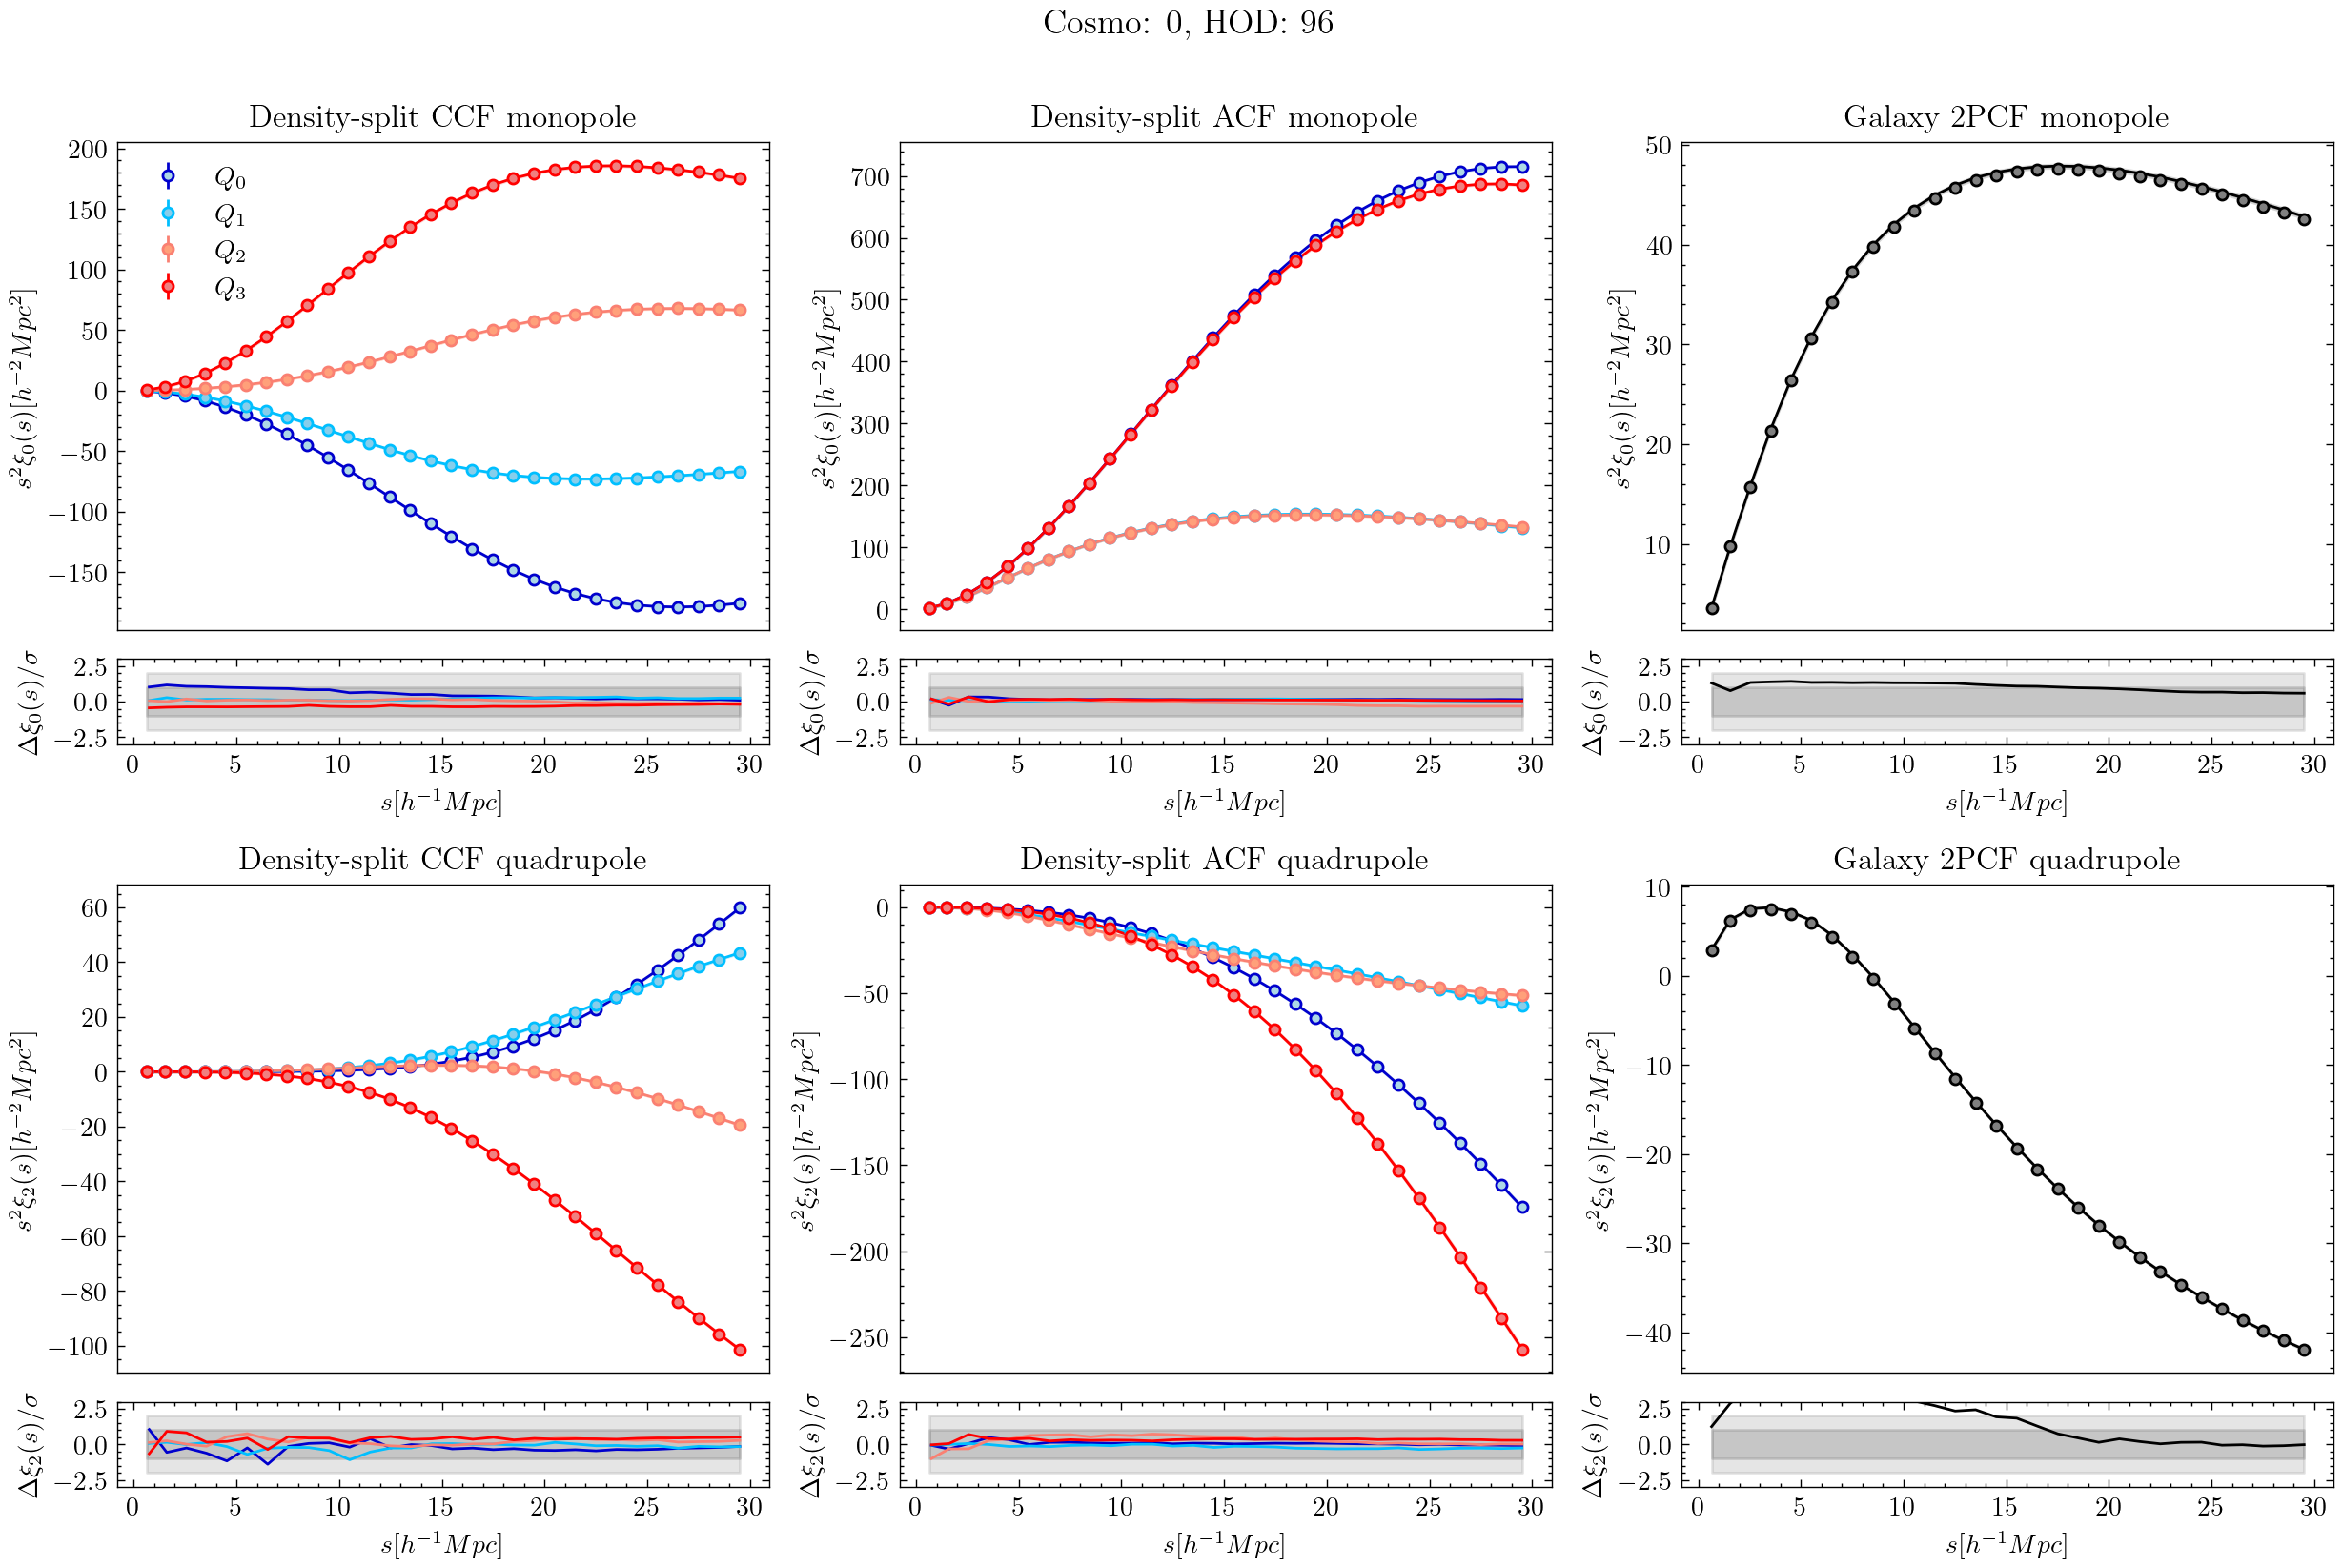

In [86]:
# Figure setup
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(4, 3, height_ratios=[2, 0.35, 2, 0.35], hspace=0.05, figure=fig)
gs_top = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[0,:], hspace=0.1, height_ratios=[2, 0.35])
gs_bottom = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs[2,:], hspace=0.1, height_ratios=[2, 0.35])

ax = np.array([[fig.add_subplot(gs_top[0,0]), fig.add_subplot(gs_top[0,1]), fig.add_subplot(gs_top[0,2])],
                [fig.add_subplot(gs_top[1:,0]), fig.add_subplot(gs_top[1:,1]), fig.add_subplot(gs_top[1:,2])],
                [fig.add_subplot(gs_bottom[0,0]), fig.add_subplot(gs_bottom[0,1]), fig.add_subplot(gs_bottom[0,2])],
                [fig.add_subplot(gs_bottom[1,0]), fig.add_subplot(gs_bottom[1,1]), fig.add_subplot(gs_bottom[1,2])]])

for observable in Observables.observables : 
    statistic = observable.stat_name
    s = observable.bin_values
    
    coords = summary_coords(
        statistic, 
        coord_type='emulator_error', 
        bin_values=s, 
        summary_coords_dict=observable.summary_coords_dict,
    )
    
    dimensions = [len(d) for d in coords.values()]

    # get reshaped arrays
    truth = observable.lhc_y.reshape(dimensions)
    prediction = observable.get_model_prediction(observable.lhc_x).reshape(dimensions)
    covariance_matrix = observable.get_covariance_matrix()
    truth_error = np.sqrt(np.diag(covariance_matrix)).reshape(dimensions)
    prediction_error = observable.emulator_error.reshape(dimensions)
    
    residual_error = np.sqrt(np.diag(covariance_matrix) + observable.emulator_error**2).reshape(dimensions)
    
    n_stats = len(coords.get('statistics', [None]))
    n_quantiles = len(coords.get('quantiles', [None]))
    n_multipoles = len(coords.get('multipoles', [None]))
    
    for stat in range(n_stats):
        for p in range(n_multipoles):
            ax_idx, ax_err_idx = get_axis(stat, p, statistic)
            
            for q in range(n_quantiles):
                ec, fc = get_color(q, statistic)
                stat_idx = get_tuple(stat, q, p, n_quantiles)
                
                ax[ax_idx].errorbar(
                    s, 
                    s**2*truth[stat_idx], 
                    yerr = s**2*truth_error[stat_idx]*error_factor, 
                    fmt = 'o', 
                    markersize = 4, 
                    mec = ec, 
                    mfc = fc, 
                    ecolor = ec, 
                    label = f'$Q_{q}$',
                )
                ax[ax_idx].plot(s, s**2*prediction[stat_idx], color=ec)
                ax[ax_idx].fill_between(
                    s, 
                    s**2*(prediction[stat_idx] - prediction_error[stat_idx]*error_factor), 
                    s**2*(prediction[stat_idx] + prediction_error[stat_idx]*error_factor), 
                    alpha = 0.3, 
                    color = fc,
                )
                ax[ax_err_idx].plot(s, (prediction[stat_idx] - truth[stat_idx])/(residual_error[stat_idx]), color=ec)

fig, ax = make_pretty(fig, ax, s)

fig.suptitle(f'Cosmo: {cosmo}, HOD: {hod}', fontsize=13, y=0.95);